In [25]:
import librosa
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression

In [26]:
import os
import re
import numpy as np
import pandas as pd
import librosa as lr
import soundfile as sf


# Pre-processing the data (Dezhi code)

In [27]:
pattern = r"\[\s?say\s(?:'?[A-Za-z ]*[A-Za-z]-[A-Za-z\- ]*'?)\s?[^\]]+\]"

content = "[say 'Ah-P-Eee' repeatedly]"
if re.search(pattern, content):
  print(True)

True


In [28]:
#select nonwords files

def check_nonwords(file_path):

    '''
    Check if a file is a nonwords file.
    We identify the nonwords files by checking its corresponding transcription file (in the prompts folder).
    The transcription of nonwords files should contain the phrase "[say Ah-P-Eee repeatedly]".
    '''

    # Define a regex pattern to match the phrase "[say Ah-P-Eee repeatedly]"
    pattern = r"\[\s?say\s(?:'?[A-Za-z ]*[A-Za-z]-[A-Za-z\- ]*'?)\s?[^\]]+\]"

    try:
        with open(file_path, 'r') as file:
            content = file.read()
            if re.search(pattern, content):  # Check if pattern matches
                return True
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return False


def find_nonwords(folder_path):
    """
    Find all nonwords .txt files in the prompt file that fits the targeting criteria.
    """
    nonwords_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            if check_nonwords(file_path):   # Check if the file is a nonwords file, if so, add it to the list
                file_name = file_name.split('.')[0]  #extract the file name without the extension
                nonwords_files.append(file_name)

    return nonwords_files


In [29]:
# read the audio files for each participant and add participant ID to the audio data

def read_audio_files(directory): #the directory here is the participant folder
    """
    The dataset structure is as follows:
    - Each participant has a folder named with the participant's ID, e.g., F01
    - Each participant folder contains multiple session folders, e.g., Session1, Session2, ...
    - Each session folder contains a prompts folder with the transcription files and a wav_headMic folder with the audio files

    - The audio files are named with the format: [file_name].wav
    - The transcription files are named with the format: [file_name].txt

    This function reads the audio files for each participant and returns a list of audio data.
    """
    # find session folders
    session_folders = [folder for folder in os.listdir(directory) if folder.startswith('Session')]
    print(f"Found {len(session_folders)} session folders in participant {directory}")
    # locate the wav_headMic folder and read the audio files
    audio_data = []
    for session_folder in session_folders:
        nonwords_files = find_nonwords(os.path.join(directory, session_folder, 'prompts'))   # select the nonwords files
        print(f"Found {len(nonwords_files)} nonwords files in session {session_folder}")

        audio_folder_head = os.path.join(directory, session_folder, 'wav_headMic')   # locate the audio folder
        audio_folder_array = os.path.join(directory, session_folder, 'wav_arrayMic')   # locate the audio folder

        #first use the headmic folder to read the audio files, if not found, use the arraymic folder
        if os.path.exists(audio_folder_head):
            audio_folder = audio_folder_head
        else:
            audio_folder = audio_folder_array

        # read the audio files
        for file_name in os.listdir(audio_folder):

            if file_name.split('.')[0] not in nonwords_files:  # check if the file is in the prompt_files, if not, continue
                file_path = os.path.join(audio_folder, file_name)     # read the audio file

                try:   #Attempt to load the .wav file
                    audio, sample_rate = sf.read(file_path)
                    audio_data.append(audio)

                except Exception as e:
                    # Print the file name and the error message if there's an issue
                    print(f"Problem with file {file_name}: {e}")
    return audio_data

In [30]:
# read the audio files for participants, add participant ID to the audio data
def participant_audios(directory):

    participant_audio = []
    for participant in os.listdir(directory):
        participant_folder = os.path.join(directory, participant)
        if os.path.isdir(participant_folder):
            print(f"Reading audio files for participant {participant}")
            audio_data = read_audio_files(participant_folder)
            #store in the audio data for each participant in a Dataframe
            #audio_data_df = pd.DataFrame(audio_data, columns=['Audio'])
            # add the participant ID to the audio data
            #audio_data_df['Participant'] = participant
            print(f"Read {len(audio_data)} audio files for participant {participant}")
            print('-----------------------------------')
            participant_audio.append(audio_data)
    return participant_audio

In [31]:
# directories groups of participants
'''
    Four groups in total: F, M, FC, MC
    F: female patients
    M: male patients
    FC: female control
    MC: male control
'''
directory_F = r'/Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/F'
directory_M = r'/Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/M'
directory_FC = r'/Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/FC'
directory_MC = r'/Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/MC'



# Pre-processing the data (Marieme)

In [32]:
# read the audio files for each participant

def store_file_paths(directory): #the directory here is the participant folder
    """
    The dataset structure is as follows:
    - Each participant has a folder named with the participant's ID, e.g., F01
    - Each participant folder contains multiple session folders, e.g., Session1, Session2, ...
    - Each session folder contains a prompts folder with the transcription files and a wav_headMic folder with the audio files

    - The audio files are named with the format: [file_name].wav
    - The transcription files are named with the format: [file_name].txt

    This function reads the audio files for each participant and returns a list of audio data.
    """
    # find session folders
    session_folders = [folder for folder in os.listdir(directory) if folder.startswith('Session')]
    print(f"Found {len(session_folders)} session folders in participant {directory}")
    # locate the wav_headMic folder and read the audio files
    paths = []
    for session_folder in session_folders:
        nonwords_files = find_nonwords(os.path.join(directory, session_folder, 'prompts'))   # select the nonwords files
        print(f"Found {len(nonwords_files)} nonwords files in session {session_folder}")

        audio_folder_head = os.path.join(directory, session_folder, 'wav_headMic')   # locate the audio folder
        audio_folder_array = os.path.join(directory, session_folder, 'wav_arrayMic')   # locate the audio folder

        #first use the headmic folder to read the audio files, if not found, use the arraymic folder
        if os.path.exists(audio_folder_head):
            audio_folder = audio_folder_head
        else:
            audio_folder = audio_folder_array

        # read the audio files
        for file_name in os.listdir(audio_folder):

            if file_name.split('.')[0] not in nonwords_files:  # check if the file is in the prompt_files, if not, continue
                file_path = os.path.join(audio_folder, file_name)     # read the audio file
                paths.append(file_path)
    return paths

In [33]:
# Function to create a DataFrame of participants and file paths
def participant_files(directory):
    data = []  # List to store participant and file path information

    for participant in os.listdir(directory):
        participant_folder = os.path.join(directory, participant)
        if os.path.isdir(participant_folder):
            file_paths = store_file_paths(participant_folder)

            # Append each file path along with the participant name
            for path in file_paths:
                data.append({'Participant': participant, 'Path': path})

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)
    return df

In [34]:
data_F = participant_files(directory_F)

Found 3 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/F/F03
Found 0 nonwords files in session Session3
Found 0 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/F/F04
Found 0 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 1 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/F/F01
Found 4 nonwords files in session Session1


In [35]:
data_M = participant_files(directory_M)

Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/M/M01
Found 3 nonwords files in session Session1
Found 0 nonwords files in session Session2_3
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/M/M04
Found 3 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 1 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/M/M03
Found 0 nonwords files in session Session2
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/M/M02
Found 0 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/M/M05
Found 0 nonwords files in session Session2

In [36]:
# Concatenate the DataFrames
with_dysarthria = pd.concat([data_F, data_M], ignore_index=True)

# Add a new column and assign 1 to all rows
with_dysarthria['hasDysarthria'] = 1

print(with_dysarthria)

     Participant                                               Path  \
0            F03  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
1            F03  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
2            F03  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
3            F03  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
4            F03  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
...          ...                                                ...   
3293         M05  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
3294         M05  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
3295         M05  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
3296         M05  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   
3297         M05  /Users/dezhizhao/Desktop/Exchange/Study/Audio ...   

      hasDysarthria  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
...            

In [37]:
data_FC = participant_files(directory_FC)
data_MC = participant_files(directory_MC)

# Concatenate the DataFrames
without_dysarthria = pd.concat([data_FC, data_MC], ignore_index=True)

# Add a new column and assign 0 to all rows
without_dysarthria['hasDysarthria'] = 0

Found 3 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/FC/FC03
Found 0 nonwords files in session Session3
Found 0 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/FC/FC02
Found 4 nonwords files in session Session3
Found 3 nonwords files in session Session2
Found 1 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/FC/FC01
Found 3 nonwords files in session Session1
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/MC/MC02
Found 0 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 2 session folders in participant /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset

In [38]:
# Concatenate the DataFrames
data = pd.concat([with_dysarthria, without_dysarthria], ignore_index=True)

In [39]:
# Remove the two rows where we can't read the files
data = data[~data['Path'].isin(['gdrive/My Drive/api-data/F/F01/Session1/wav_headMic/0068.wav',
                          'gdrive/My Drive/api-data/F/F01/Session1/wav_headMic/0067.wav'])]

# Extracting Features

In [40]:
# extract the MFCC features and do the data augmentation

# Initialize an empty list for augmented data
mfcc_processed = []

# Iterate through each row in the DataFrame
for _, row in data.iterrows():
    try:
        # Load the audio file
        y, sr = librosa.load(row['Path'], sr=None)

        # Original MFCC
        mfcc_original = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
        mfcc_processed.append({
            'MFCC': np.mean(mfcc_original, axis=1),
            'Class': row['hasDysarthria'],
            'Participant': row['Participant']
        })


    except Exception as e:
        print(f"Error processing file {row['Path']}: {e}")

# Convert augmented data into a DataFrame
df_mfcc = pd.DataFrame(mfcc_processed)

# Expand the MFCC features into separate columns
mfcc_features = pd.DataFrame(df_mfcc['MFCC'].to_list(), columns=[f'MFCC_{i}' for i in range(128)])

# Concatenate the expanded MFCCs with the class labels and participant data
final_df = pd.concat([mfcc_features, df_mfcc['Class'], df_mfcc['Participant']], axis=1)



/var/folders/5z/555k98mj58g_jrdbhpdfsl480000gn/T/ipykernel_96862/2414890650.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(row['Path'], sr=None)
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/F/F01/Session1/wav_headMic/0067.wav: 
Error processing file /Users/dezhizhao/Desktop/Exchange/Study/Audio processing and indexing/Project/dataset/F/F01/Session1/wav_headMic/0068.wav: 


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=405
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=137
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is to

In [41]:
# Display info about the augmented dataset
print(final_df.info())



# Display the class distribution
print(final_df['Class'].value_counts())

# Display the participant distribution
print(final_df['Participant'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9133 entries, 0 to 9132
Columns: 130 entries, MFCC_0 to Participant
dtypes: float32(128), int64(1), object(1)
memory usage: 4.6+ MB
None
Class
0    5837
1    3296
Name: count, dtype: int64
Participant
FC02    1262
MC01    1105
MC04    1024
FC03     999
MC03     825
F03      574
M05      520
MC02     461
F04      446
M03      421
M04      418
M02      406
M01      383
FC01     161
F01      128
Name: count, dtype: int64


# data augmentation

In [19]:
def pad_or_truncate(signal, length):
    """Ensure the audio signal is of a specified fixed length."""
    if len(signal) > length:
        return signal[:length]  # Truncate the signal
    else:
        return np.pad(signal, (0, length - len(signal)), 'constant')  # Pad with zeros

def augment_data(X_train, y_train, fixed_length=128):
    """
    Apply data augmentation (time stretching and adding noise) to training data,
    ensuring all signals have the same length.

    Parameters:
        X_train (array): Array of training audio signals.
        y_train (array): Array of labels corresponding to X_train.
        fixed_length (int): Fixed length for audio signals (default: 22050 samples).

    Returns:
        X_train_augmented (array): Augmented training data with fixed lengths.
        y_train_augmented (array): Corresponding labels for augmented data.
    """
    augmented_X_train = []
    augmented_y_train = []

    for x, y in zip(X_train, y_train):
        # Ensure original signal is of fixed length
        x_fixed = pad_or_truncate(x, fixed_length)
        augmented_X_train.append(x_fixed)
        augmented_y_train.append(y)

        # Augmentation 1: Time Stretching
        try:
            x_stretched = librosa.effects.time_stretch(x, rate=1.2)  # Stretch audio (20% faster)
            x_stretched_fixed = pad_or_truncate(x_stretched, fixed_length)
            augmented_X_train.append(x_stretched_fixed)
            augmented_y_train.append(y)
        except Exception as e:
            print(f"Error in time stretching: {e}")

        # Augmentation 2: Adding Noise
        try:
            noise = np.random.normal(0, 0.005, len(x))  # Gaussian noise
            x_noisy = x + noise
            x_noisy_fixed = pad_or_truncate(x_noisy, fixed_length)
            augmented_X_train.append(x_noisy_fixed)
            augmented_y_train.append(y)
        except Exception as e:
            print(f"Error in adding noise: {e}")

    return np.array(augmented_X_train), np.array(augmented_y_train)



# Baseline model using logistic regression

In [21]:
# baseline model using logistic regression

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=5)

X = final_df.iloc[:, :-2].values  # All columns except the last two
y = final_df.iloc[:, -2].values   # Second to last column

# Perform cross-validation and implement the logistic regression model

for train_idx, test_idx in group_kfold.split(X, y, groups=final_df['Participant']):
    X_train = np.array([X[i] for i in train_idx])
    X_test = np.array([X[i] for i in test_idx])
    y_train = y[train_idx]
    y_test = y[test_idx]

    #data augmentation
    X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

    # normalize the augmented data
    scaler = StandardScaler()

    # Normalize the MFCC features
    X_train_augmented = scaler.fit_transform(X_train_augmented)

    # Ensure that the total features in X match the reshape dimensions
    if X_train_augmented.shape[1] != 128:  # Verify feature count
        raise ValueError("Expected 128 features per sample. Check your MFCC extraction.")


    #set up the logistic regression model
    model = LogisticRegression(max_iter=1000, class_weight='balanced')


    #train the model
    model.fit(X_train_augmented, y_train_augmented)

    # After training, compute the scores on the test set
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    con_mtr = confusion_matrix(y_test, y_pred, labels=[1, 0])

    print(f'class distribution in test set: {np.bincount(y_test)}')
    print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{con_mtr}')


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(


class distribution in test set: [1262  549]
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Accuracy: 0.6968525676421866
Confusion Matrix:
[[   0  549]
 [   0 1262]]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(


class distribution in test set: [1266  446]
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Accuracy: 0.7394859813084113
Confusion Matrix:
[[   0  446]
 [   0 1266]]
class distribution in test set: [1485  406]
Precision: 0.2314881380301941, Recall: 0.7931034482758621, F1 Score: 0.3583750695603784
Accuracy: 0.390269698572184
Confusion Matrix:
[[ 322   84]
 [1069  416]]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(


class distribution in test set: [999 903]
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Accuracy: 0.5252365930599369
Confusion Matrix:
[[  0 903]
 [  0 999]]
class distribution in test set: [825 992]
Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Accuracy: 0.45404512933406715
Confusion Matrix:
[[  0 992]
 [  0 825]]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Building the model

In [23]:
# use groupKFold to split the data

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=5)

X = final_df.iloc[:, :-2].values  # All columns except the last two
y = final_df.iloc[:, -2].values   # Second to last column
group_ids = final_df.iloc[:, -1].values  # Second to last column

# Perform cross-validation
for train_idx, test_idx in group_kfold.split(X, y, groups=group_ids):
    X_train = np.array([X[i] for i in train_idx])
    X_test = np.array([X[i] for i in test_idx])
    y_train = y[train_idx]
    y_test = y[test_idx]


    #data augmentation
    X_train_augmented, y_train_augmented = augment_data(X_train, y_train)


    # normalize the augmented data
    scaler = StandardScaler()

    # Normalize the MFCC features
    X_train_augmented = scaler.fit_transform(X_train_augmented)

    # Ensure that the total features in X match the reshape dimensions
    if X_train_augmented.shape[1] != 128:  # Verify feature count
        raise ValueError("Expected 128 features per sample. Check your MFCC extraction.")

    # Assuming a 16x8 grid for each sample
    # Reshape into 4D tensors: (samples, 16, 8, 1)
    X_train_augmented = X_train_augmented.reshape(-1, 16, 8, 1)
    X_test = X_test.reshape(-1, 16, 8, 1)


    #set up the model
    model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),  # Input layer with specified shape
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # Dropout for regularization
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # Dropout for regularization
    Flatten(),  # Flatten before passing to dense layers
    Dense(64, activation='relu'),
    BatchNormalization(),  # Batch normalization for stability
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Final output layer for binary classification
    ])

    # Model Summary
    model.summary()



    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))


    #train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_augmented, y_train_augmented, epochs=25, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping, reduce_lr], class_weight= class_weights)

    # After training, compute the scores on the test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)  # Convert to binary predictions

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    con_mtr = confusion_matrix(y_test, y_pred, labels=[1, 0])

    print(f'class distribution in test set: {np.bincount(y_test)}')
    print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{con_mtr}')








/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,465 (556.50 KB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8591 - loss: 0.3161 - val_accuracy: 0.5787 - val_loss: 12.3786 - learning_rate: 0.0010
Epoch 2/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9770 - loss: 0.0657 - val_accuracy: 0.4655 - val_loss: 18.2588 - learning_rate: 0.0010
Epoch 3/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9855 - loss: 0.0437 - val_accuracy: 0.3031 - val_loss: 66.9990 - learning_rate: 0.0010
Epoch 4/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9924 - loss: 0.0239 - val_accuracy: 0.3031 - val_loss: 95.3504 - learning_rate: 5.0000e-04
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
class distribution in test set: [1262  549]
Precision: 0.4184451219512195, Recall: 1.0, F1 Score: 0.5900053734551316
Accuracy: 0.5786858089453341
Confusion Matrix:
[[549   0]
 [763 499]]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,465 (556.50 KB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8687 - loss: 0.3051 - val_accuracy: 0.6022 - val_loss: 5.3012 - learning_rate: 0.0010
Epoch 2/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9813 - loss: 0.0538 - val_accuracy: 0.2605 - val_loss: 34.1137 - learning_rate: 0.0010
Epoch 3/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0.2605 - val_loss: 81.1052 - learning_rate: 0.0010
Epoch 4/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9910 - loss: 0.0242 - val_accuracy: 0.2605 - val_loss: 104.2284 - learning_rate: 5.0000e-04
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
class distribution in test set: [1266  446]
Precision: 0.28440366972477066, Recall: 0.3475336322869955, F1 Score: 0.31281533804238143
Accuracy: 0.6022196261682243
Confusion Matrix:
[[155 291]
 [390 876]]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,465 (556.50 KB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8531 - loss: 0.3431 - val_accuracy: 0.2348 - val_loss: 33.0344 - learning_rate: 0.0010
Epoch 2/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9801 - loss: 0.0582 - val_accuracy: 0.4072 - val_loss: 3.9966 - learning_rate: 0.0010
Epoch 3/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9874 - loss: 0.0365 - val_accuracy: 0.3189 - val_loss: 8.3938 - learning_rate: 0.0010
Epoch 4/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9903 - loss: 0.0303 - val_accuracy: 0.2316 - val_loss: 50.6012 - learning_rate: 0.0010
Epoch 5/25
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9919 - loss: 0.0214 - val_accuracy: 0.2195 - val_loss: 37.8261 - learning_rate: 5.0000e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
class distribution in test set: [1485  406]
Precision: 0.2243639167309175, Recall: 0.7167487684729064, F1 Score: 0.3417498532002349
Accuracy: 0.4071919619249075
Confusion Matrix:
[[ 291  115]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,465 (556.50 KB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8759 - loss: 0.2947 - val_accuracy: 0.4742 - val_loss: 10.3687 - learning_rate: 0.0010
Epoch 2/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9811 - loss: 0.0560 - val_accuracy: 0.4727 - val_loss: 21.4471 - learning_rate: 0.0010
Epoch 3/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9871 - loss: 0.0349 - val_accuracy: 0.4721 - val_loss: 27.2464 - learning_rate: 0.0010
Epoch 4/25
678/678 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9933 - loss: 0.0220 - val_accuracy: 0.4737 - val_loss: 22.8930 - learning_rate: 5.0000e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
class distribution in test set: [999 903]
Precision: 0.47446024223275407, Recall: 0.9977851605758582, F1 Score: 0.643112062812277
Accuracy: 0.47423764458464773
Confusion Matrix:
[[901   2]
 [998   1]]


/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/Users/dezhizhao/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 16, 8, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 8, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,465 (556.50 KB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
686/686 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8705 - loss: 0.2947 - val_accuracy: 0.6021 - val_loss: 17.9532 - learning_rate: 0.0010
Epoch 2/25
686/686 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9776 - loss: 0.0633 - val_accuracy: 0.5460 - val_loss: 37.1996 - learning_rate: 0.0010
Epoch 3/25
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9839 - loss: 0.0464 - val_accuracy: 0.5460 - val_loss: 71.4576 - learning_rate: 0.0010
Epoch 4/25
686/686 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9909 - loss: 0.0271 - val_accuracy: 0.6621 - val_loss: 56.6855 - learning_rate: 5.0000e-04
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
class distribution in test set: [825 992]
Precision: 0.5786090005844535, Recall: 0.9979838709677419, F1 Score: 0.732519422863485
Accuracy: 0.6020913593835994
Confusion Matrix:
[[990   2]
 [721 104]]


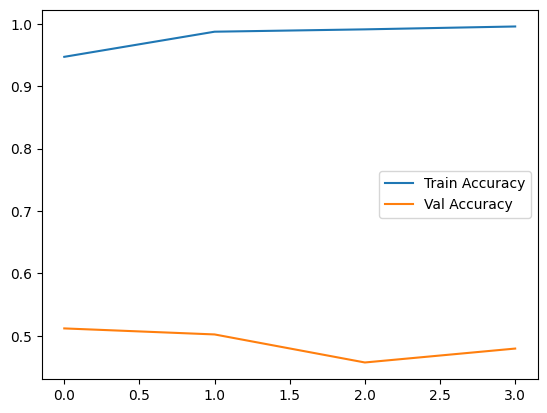

In [26]:
# Plot training vs validation loss/accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.savefig('accuracy.png')
